In [1]:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Functions to be used:

In [76]:
def clean_data(df):
    df.columns = df.iloc[0]
    len_df = df.count().max() + 1 
    df.drop(df.index[[0, (len_df-3), (len_df-2), (len_df-1), len_df]],inplace=True) #dropping rows that we don't need 
    
#Need to convert interest rate and revolver utilization into numbers through another way, as percentage sign is a problem 
def numeric_fix(df):
    df['int_rate'] = df['int_rate'].map(lambda x: x.rstrip('%'))
    df['revol_util'] = df['revol_util'].map(lambda x: x.rstrip('%'))
    df[['annual_inc','dti','total_acc','revol_bal','open_acc','mort_acc','int_rate','revol_util']] = df[['annual_inc','dti','total_acc','revol_bal','open_acc','mort_acc','int_rate','revol_util']].apply(pd.to_numeric)
    df['int_rate'] = df['int_rate'].map(lambda x: x/100)
    df['revol_util'] = df['revol_util'].map(lambda x: x/100)
    
def master_class(row):
    if row['loan_status'] == 'Current' or row['loan_status'] == 'Fully Paid'or row['loan_status'] == 'In Grace Period'or row['loan_status'] == 'Late (16-30 days)':
        return 1 #1 for a GOOD loan
    else:
        return 0 #0 fro a BAD loan 
    

# Loading Data Correctly

In [77]:
# CORRECT way to load the data
df = pd.read_csv("LoanStats_2015.csv")
clean_data(df)
df = df[['grade','sub_grade','home_ownership','annual_inc','int_rate','loan_status','dti','total_acc','revol_bal'
          ,'revol_util','open_acc','pymnt_plan','emp_length','mort_acc']]
df.dropna(inplace=True)
numeric_fix(df)

# Initial Overview

Will look at correlations and pairplots for this data set as well. Want to see if also getting outliers in DTI

In [55]:
df.corr()

,annual_inc,int_rate,dti,total_acc,revol_bal,revol_util,open_acc,mort_acc
0,,,,,,,,
annual_inc,1.000000,-0.090462,-0.068202,0.159864,0.269999,0.039404,0.122508,0.209012
int_rate,-0.090462,1.000000,0.077962,-0.040178,-0.057349,0.200654,-0.012727,-0.076200
dti,-0.068202,0.077962,1.000000,0.080495,0.048183,0.065792,0.104341,-0.020021
total_acc,0.159864,-0.040178,0.080495,1.000000,0.180352,-0.131712,0.709633,0.356488
revol_bal,0.269999,-0.057349,0.048183,0.180352,1.000000,0.230265,0.223115,0.200739
revol_util,0.039404,0.200654,0.065792,-0.131712,0.230265,1.000000,-0.157639,0.012938
open_acc,0.122508,-0.012727,0.104341,0.709633,0.223115,-0.157639,1.000000,0.117511
mort_acc,0.209012,-0.076200,-0.020021,0.356488,0.200739,0.012938,0.117511,1.000000


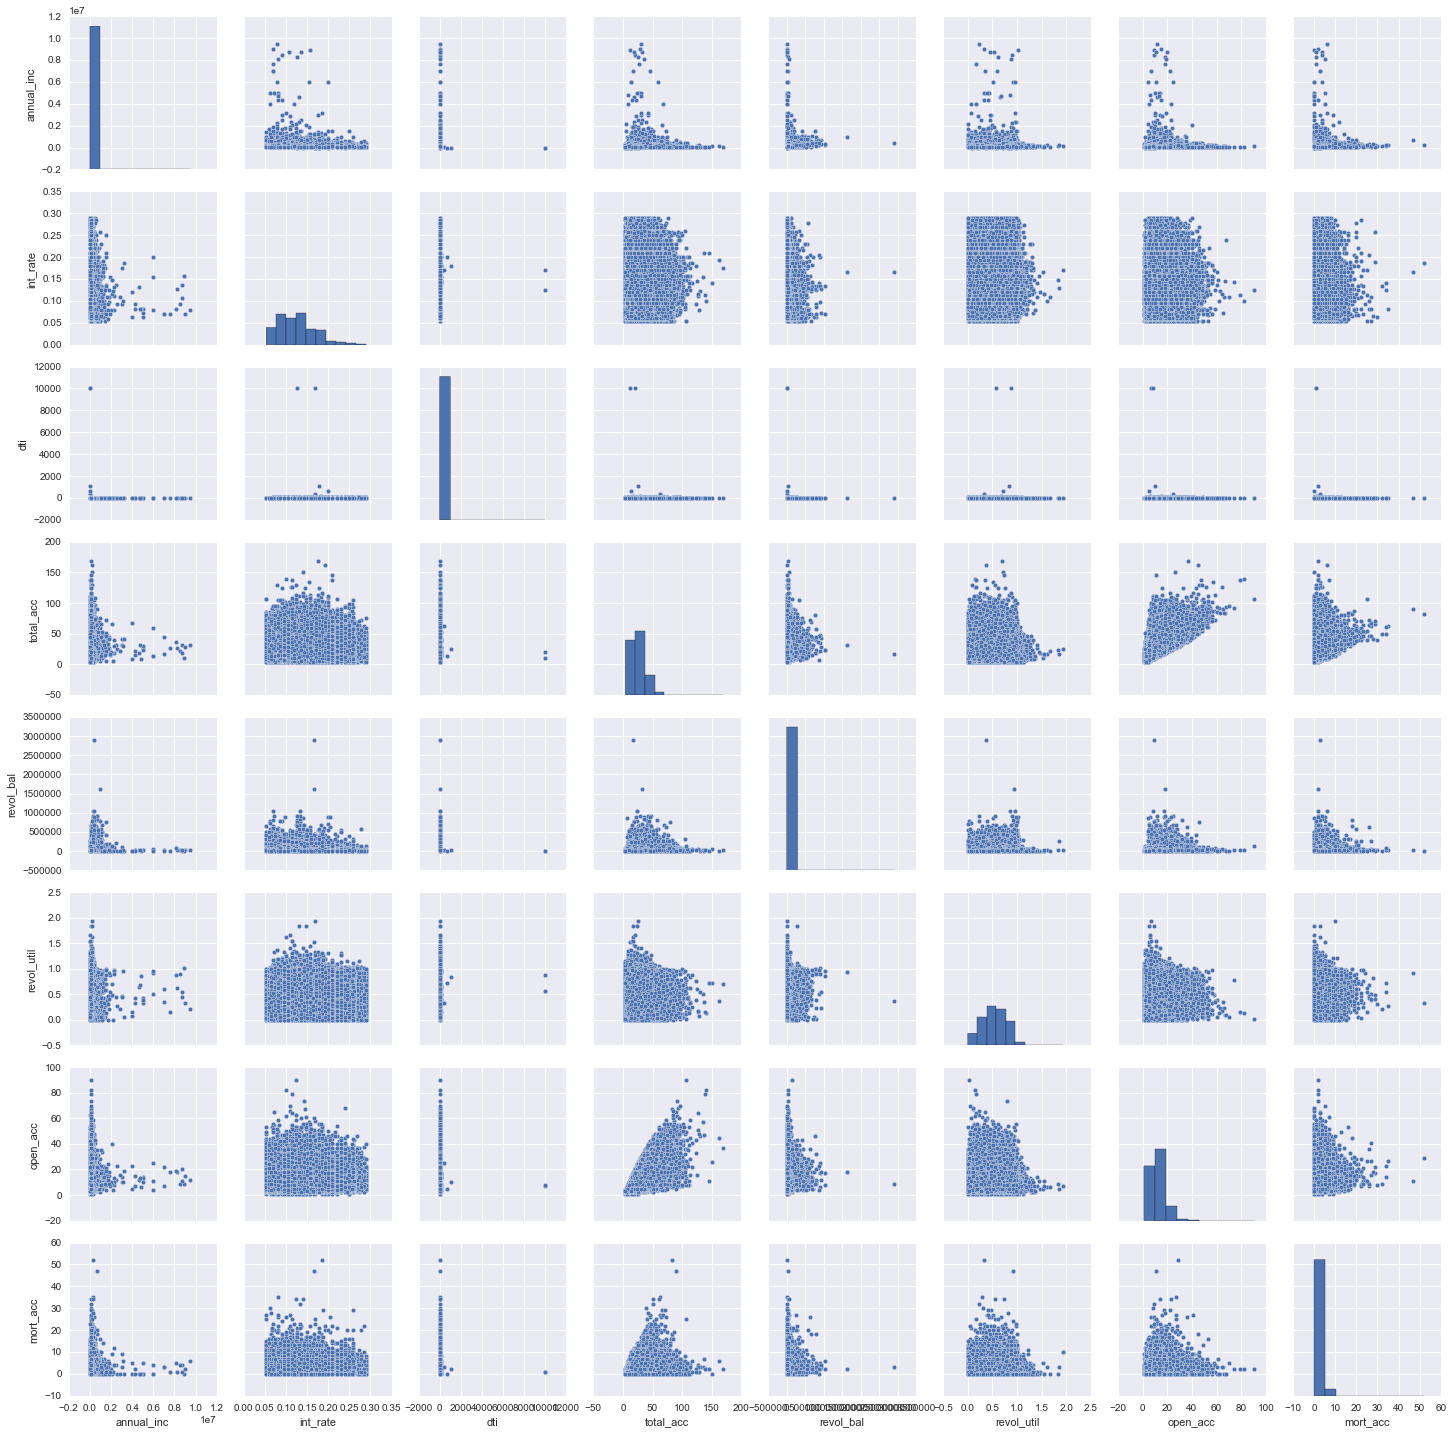

In [56]:
sns.pairplot(df);

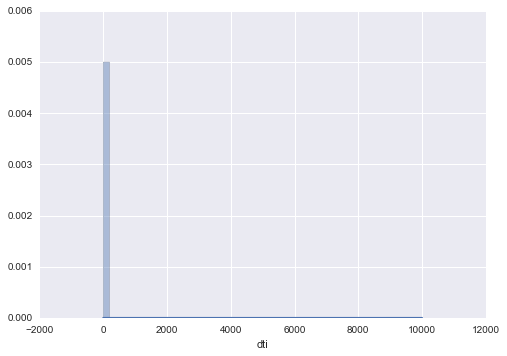

In [7]:
sns.distplot(df.dti)

Will eliminate the outliers where DTI is larger than 100. Seems to be some error in the recording.

In [78]:
df2 = df[df.dti < 100]

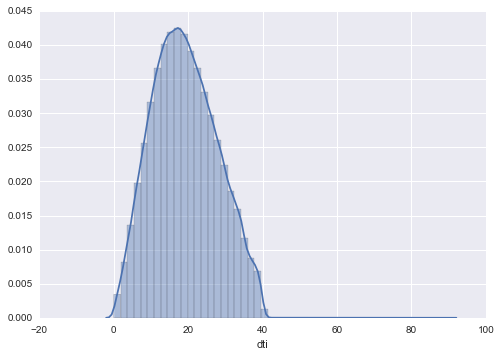

In [9]:
sns.distplot(df2.dti)

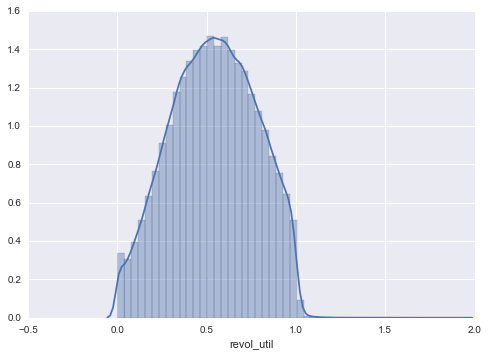

In [10]:
sns.distplot(df2.revol_util)

Revolver utilization and DTI seem to be normally distributed.  

In [11]:
df2.loan_status.value_counts(dropna=False)

Current               317121
Fully Paid             67708
Charged Off            19523
Late (31-120 days)      9804
In Grace Period         3858
Late (16-30 days)       2485
Default                  423
Name: loan_status, dtype: int64

Issued: New loan that has passed all Lending Club reviews, received full funding, and has been issued.
 
Not Yet Issued: Includes loan requests that are In Funding, loan requests that are In Review, and Notes that are Issuing. 

Current: Loan is up to date on all outstanding payments. 
 
In Grace Period: Loan is past due but within the 15-day grace period. 
 
Late (16-30): Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
 
Late (31-120): Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
 
Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

Default: Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.
 
Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

In [12]:
df2.head()

,grade,sub_grade,home_ownership,annual_inc,int_rate,loan_status,dti,total_acc,revol_bal,revol_util,open_acc,pymnt_plan,emp_length,mort_acc
1,A,A1,MORTGAGE,53750.0,0.0532,Current,15.30,19.0,3172.0,0.172,8.0,n,4 years,2.0
2,C,C2,MORTGAGE,64000.0,0.1288,Current,34.95,24.0,37828.0,0.672,17.0,n,3 years,4.0
3,B,B4,MORTGAGE,63000.0,0.1078,Current,10.78,18.0,7869.0,0.562,6.0,n,10+ years,5.0
4,C,C4,MORTGAGE,79000.0,0.1399,Current,34.53,72.0,22519.0,0.186,33.0,n,9 years,6.0
5,E,E3,RENT,55000.0,0.1989,Fully Paid,25.49,19.0,9568.0,0.460,18.0,n,8 years,0.0


# Logistic Regression and Classfication Analysis on the New Master Classes

Current               GOOD;
Fully Paid             GOOD;
Charged Off            BAD;
Late (31-120 days)      BAD;
In Grace Period         GOOD;
Late (16-30 days)       GOOD;
Default                  BAD;

In [79]:
##applying the master_class function
df2['Master_Status'] = df2.apply(master_class, axis=1)
###########

/Users/luisfelipevelez/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [80]:
df2.loan_status.value_counts(dropna=False)

Current               317121
Fully Paid             67708
Charged Off            19523
Late (31-120 days)      9804
In Grace Period         3858
Late (16-30 days)       2485
Default                  423
Name: loan_status, dtype: int64

In [81]:
df2.Master_Status.value_counts(dropna=False)

1    391172
0     29750
Name: Master_Status, dtype: int64

Want to see the individual influence of two predictor variables on our classifier. The two predictor variables I will use are both continuous, and are the two that seem to be closely normal in distribution: DTI (debt to income ratio) and Revol_util (revolver utilization).

In [59]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [23]:
lm = LogisticRegression()
lm.fit(df2[['dti']], df2['Master_Status'])
print "A unit change in dti, changes log odds by:", lm.coef_
print "A unit change in dti, changes odds by:", np.exp(lm.coef_)

A unit change in dti, changes log odds by: [[-0.02876073]]
A unit change in dti, changes odds by: [[ 0.97164892]]


In [24]:
lm2 = LogisticRegression()
lm2.fit(df2[['revol_util']], df2['Master_Status'])
print "A unit change in dti, changes log odds by:", lm2.coef_
print "A unit change in dti, changes odds by:", np.exp(lm2.coef_)

A unit change in dti, changes log odds by: [[-0.38338393]]
A unit change in dti, changes odds by: [[ 0.68155118]]


In [25]:
lm3 = LogisticRegression()
feature_set = df2[['dti', 'revol_util']]
lm3.fit(feature_set, df2['Master_Status'])
print "A unit change in dti, changes log odds by:", lm3.coef_
print "A unit change in dti, changes odds by:", np.exp(lm3.coef_)

A unit change in dti, changes log odds by: [[-0.02777366 -0.21551473]]
A unit change in dti, changes odds by: [[ 0.97260848  0.80612639]]


Using the logistic regression model with both DTI and Revolver Utilization, I'm getting an accuracy of over 92%

In [26]:
lm.score(df2[['dti']], df2['Master_Status'])

0.92932182209530512

In [27]:
lm2.score(df2[['revol_util']], df2['Master_Status'])

0.92932182209530512

In [24]:
lm3.score(feature_set, df2['Master_Status'])

0.92932182209530512

The high predictive accuracy that I get for my logistic regression models is due to the imbalanced classes underlying my analysis. Due to the fact that ~93% of my Loans 2015 Data is classified as GOOD loans, the model naturally predicts GOOD for all the loans and my result is the 92.93% accuracy that I am getting. Will have to see how to get around imbalanced data. Not sure if it is a problem for Decision Trees and Random Forests. 

Simply looking at accuracy score is not the best way to analyze whether your classification model is doing a good job. Will have to look at confusion matrix, recall, precision. 

# Use Cross Validation to better check the performance of the Log Regression models. 

Refit the Model:

In [82]:
# in this case, trying for lm3 which includes feature set of both dti and revol util
lm3 = LogisticRegression()
X =  df2[['dti', 'revol_util']]
y = df2['Master_Status']
lm3.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Try Mean of Cross Validation Score:

In [83]:
from sklearn.cross_validation import cross_val_score, KFold
cv = KFold(len(df2),n_folds=5, shuffle=True)
perf = cross_val_score(lm3, X, y, cv=cv)
print perf.mean(), perf.std()

0.92932182325 0.000732181026053


Getting same result because of unbalanced classes. Even when using cross validation, the training set concludes that the best way to get a high accuracy is to simply assign the most probable class to all predictions, thus giving me a seemingly great score. Nonetheless this is a classic example of Accuracy Paradox. Using decision trees is one of the ways in which we can get past this problem. 

# Running Decision Trees and Random Forests:

Since a simple logistic regression model was not the best way to go about performing this analysis, we will try a different model: decision trees.

At first try a decision tree using all of the predictor variables in the data set and see the score.

In [43]:
df2.emp_length.value_counts(dropna=False)

10+ years    141466
2 years       37481
< 1 year      34326
3 years       33418
1 year        27462
5 years       24920
4 years       24502
n/a           23807
8 years       21547
7 years       18405
6 years       16832
9 years       16756
Name: emp_length, dtype: int64

Emp_Length variable is giving me trouble for running the decision tree. Could fix the variable up and make a df3 model that has that fixed. Or could simply run the decision tree withouth that variable. Maybe worth fixing it and comparing results? Will do that.  

## Creating Dummy Variables (Label Encoder) for the Decision Trees:

In [84]:
######CREATING DUMMY VARIABLES FOR THE CATEGORICAL VARIABLES, IN ORDER TO PUT IN RANDOM FOREST/DECISION TREES
df2 = df2.join(pd.get_dummies(df2['grade']))
df2 = df2.join(pd.get_dummies(df2['sub_grade']))
df2 = df2.join(pd.get_dummies(df2['home_ownership'])).drop("ANY", axis=1)
df2 = df2.join(pd.get_dummies(df2['pymnt_plan']))
df2 = df2.join(pd.get_dummies(df2['emp_length']))
df2.drop(["grade", "sub_grade",'home_ownership','pymnt_plan','emp_length'], axis=1, inplace=True)
##########################################################################################################

In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420922 entries, 1 to 421095
Data columns (total 68 columns):
annual_inc       420922 non-null float64
int_rate         420922 non-null float64
loan_status      420922 non-null object
dti              420922 non-null float64
total_acc        420922 non-null float64
revol_bal        420922 non-null float64
revol_util       420922 non-null float64
open_acc         420922 non-null float64
mort_acc         420922 non-null float64
Master_Status    420922 non-null object
A                420922 non-null float64
B                420922 non-null float64
C                420922 non-null float64
D                420922 non-null float64
E                420922 non-null float64
F                420922 non-null float64
G                420922 non-null float64
A1               420922 non-null float64
A2               420922 non-null float64
A3               420922 non-null float64
A4               420922 non-null float64
A5               420922 non-nu

In [75]:
from sklearn.cross_validation import cross_val_score
cross_val_score?

In [85]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status'] 
# Fits the model
model.fit(X, y)
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.52343718  0.52271136  0.52108407  0.52393318  0.52033847], Average AUC 0.522300853705


## Control for Overfitting:

Adjust for the model by changing the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [86]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5
)
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status'] 
# Fits the model
model.fit(X, y)
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.6900049   0.70886814  0.68647823  0.67421718  0.67404166], Average AUC 0.686722020839


In [88]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
                max_depth = 4,
                min_samples_leaf = 4
)
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status'] 
# Fits the model
model.fit(X, y)
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.70603719  0.7273899   0.70317398  0.69060257  0.69024665], Average AUC 0.703490058636


In [89]:
model = DecisionTreeClassifier(
                max_depth = 6,
                min_samples_leaf = 3
)
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status'] 
# Fits the model
model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.70543921  0.73011352  0.70548563  0.6918896   0.68988613], Average AUC 0.704562818745


In [90]:
model = DecisionTreeClassifier(
                max_depth = 8,
                min_samples_leaf = 3
)
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status'] 
# Fits the model
model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.69931013  0.72726333  0.70270651  0.68904014  0.68209154], Average AUC 0.700082330852


As I can see, it comes to a point when increasing max_depth and decreasing min_samples_leaf will give me a overfitted model and will decrease my average AUC score. From the decision tree configurations tried above, the one yielding the best results is the one with Max_depth = 6 and min_samples_leaf = 3.

## Will now try RANDOM FOREST Classifiers as this avoids overfitting automatically

In [95]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
X = df2.drop(['Master_Status','loan_status'],axis=1)
y = df2['Master_Status']
model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.62839669  0.63677749  0.63329481  0.62990567  0.62764915], Average AUC 0.631204760514


Getting worse AUC results in Forest with 20 Decision Trees than in my best manual decision Tree. Will use a for loop to increase the number of decision trees and try different sets, in order to see if I can achieve previous AUC levels again. 

In [93]:
scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))
for n_trees in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [ 0.672083    0.66759865  0.60683123], Average AUC 0.648837623822
n trees: 1, CV AUC [ 0.51885348  0.51967438  0.51964447  0.52201633  0.52309726], Average AUC 0.520657184344
n trees: 11, CV AUC [ 0.60428516  0.61855793  0.60943246  0.60062314  0.60661675], Average AUC 0.607903091236
n trees: 21, CV AUC [ 0.63206205  0.64266879  0.63060131  0.62880771  0.62594048], Average AUC 0.63201606916
n trees: 31, CV AUC [ 0.6470883   0.65797722  0.6478593   0.63969106  0.63429675], Average AUC 0.645382525494
n trees: 41, CV AUC [ 0.64824682  0.66440041  0.64993725  0.64574109  0.64380567], Average AUC 0.650426247974
n trees: 51, CV AUC [ 0.65256472  0.66979249  0.65681947  0.65201092  0.65123331], Average AUC 0.656484181145
n trees: 61, CV AUC [ 0.65907203  0.6781505   0.66157338  0.65365692  0.65047432], Average AUC 0.660585431177
n trees: 71, CV AUC [ 0.66125089  0.67770945  0.6630546   0.65672355  0.65672913], Average AUC 0.66309352472
n trees: 81, CV AUC [ 0.66557991  0.67873663  0.66

## Getting importance of Features

In [96]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
2,dti,0.146710
4,revol_bal,0.145988
5,revol_util,0.142556
0,annual_inc,0.128879
3,total_acc,0.112291
